In [1]:
from datasets import load_dataset
from utils import jpeg_compress, webp_compress, pad, crop, nn_compress, hific_lo_compress
import compressai
from evaluate import evaluator
from transformers import pipeline
import torch
import numpy as np
import matplotlib.pyplot as plt

2023-10-16 16:29:22.520003: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-16 16:29:22.520042: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-16 16:29:22.522365: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def jpeg_compress_vea(sample):
    img,bpp = jpeg_compress(sample['image'])
    sample['image'] = img
    sample['bpp' ] = bpp
    return sample
    
def webp_compress_vea(sample):
    img,bpp = webp_compress(sample['image'])
    sample['image'] = img
    sample['bpp' ] = bpp
    return sample

device = "cuda"
net_mbt2018 = compressai.zoo.mbt2018(quality=1, pretrained=True).eval().to(device)
def mbt2018_compress_vea(sample):
    img,bpp = nn_compress(sample['image'],net_mbt2018,device)
    sample['image'] = img
    sample['bpp'] = bpp
    return sample

def hific_lo_compress_vea(sample):
    img,bpp = hific_lo_compress(sample['image'])
    sample['image'] = img
    sample['bpp' ] = bpp
    return sample

In [4]:
image_compression_methods = [
    jpeg_compress_vea,
    webp_compress_vea,
    mbt2018_compress_vea,
    hific_lo_compress_vea
]
models = [
    "dennisjooo/emotion_classification"
]

In [5]:
vea = [load_dataset("FastJobs/Visual_Emotional_Analysis", split="train[:10]")]

Resolving data files:   0%|          | 0/800 [00:00<?, ?it/s]

In [6]:
for method in image_compression_methods:
    vea.append(vea[0].map(method))

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/home/server/danjacobellis/MPQ/utils.py:66: UserWarning: Inference on GPU is not recommended for the autoregressive models (the entropy coder is run sequentially on CPU).
  compressed = net.compress(x)
/home/server/danjacobellis/MPQ/utils.py:67: UserWarning: Inference on GPU is not recommended for the autoregressive models (the entropy coder is run sequentially on CPU).
  recovered  = net.decompress(compressed['strings'],shape=compressed['shape'])


In [7]:
pipe = []
for model in models:
    pipe.append(
        pipeline(
            task="image-classification",
            model=model,
            device="cuda:0"
        )
    )

In [8]:
task_evaluator = evaluator("image-classification")

In [9]:
eval_results = []
for i_method,method in enumerate(vea):
    eval_results.append([])
    for i_model,model in enumerate(pipe):
        eval_results[i_method].append(
            task_evaluator.compute(
                model_or_pipeline=model,
                data=method,
                label_column='label',
                metric="accuracy",
                label_mapping=model.model.config.label2id
            )
        )

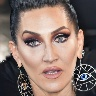

In [13]:
vea[0][0]['image']

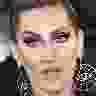

In [14]:
vea[1][0]['image']

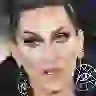

In [15]:
vea[2][0]['image']

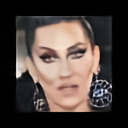

In [16]:
vea[3][0]['image']

In [10]:
classification_acc = np.array(
    [[rij['accuracy'] for rij in r] for r in eval_results]
)
classification_acc

array([[0.8],
       [0.1],
       [0.4],
       [0. ],
       [0. ]])

In [17]:
baseline_acc = classification_acc[0]
classification_acc = classification_acc[1:]

In [20]:
image_bpp = [np.mean(method['bpp']) for method in vea[1:]]
image_bpp

[0.83671875, 0.2756944444444444, 0.2548611111111111, 0.053515625]

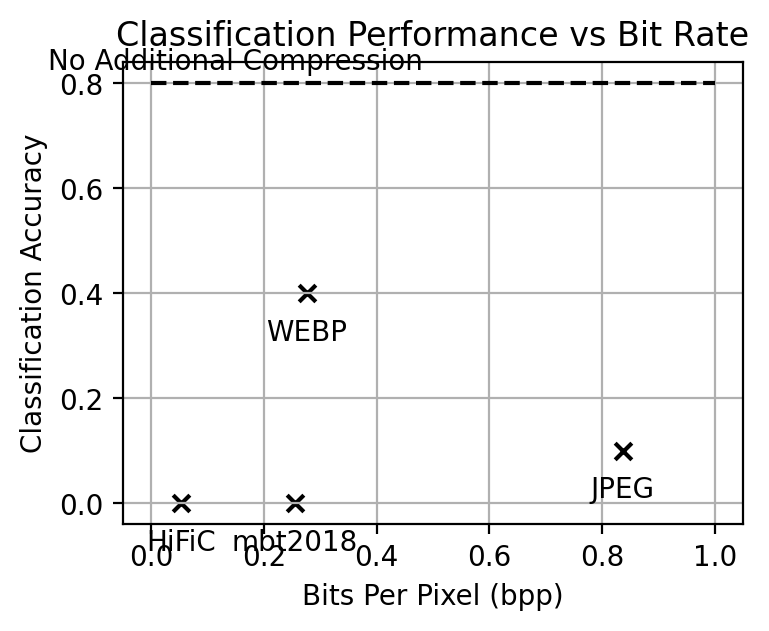

In [22]:
image_compression_names = [
    'JPEG',
    'WEBP',
    'mbt2018',
    'HiFiC'
]
plt.figure(figsize=(4, 3),dpi=200)
plt.scatter(image_bpp, classification_acc, c='black', marker='x')
plt.annotate("No Additional Compression", (0.15, baseline_acc), textcoords="offset points", xytext=(0,5), ha='center')
plt.plot([0,1],[baseline_acc,baseline_acc],'--',c='black')
for i, name in enumerate(image_compression_names):
    plt.annotate(name, (image_bpp[i], classification_acc[i]), textcoords="offset points", xytext=(0,-17), ha='center')
plt.xlabel('Bits Per Pixel (bpp)')
plt.ylabel('Classification Accuracy')
plt.title('Classification Performance vs Bit Rate')
# plt.xlim([0,0.3])
# plt.ylim([0.75,1.0])
plt.grid(True)
plt.show()